# Projet Reporting et Restitution
## Membres du groupe :
### Hugo HOUNTONDJI
### LO Maty
### HU Angel
### PASINI Giorgio

## 1_nettoyage

Ce script a pour objectif de :
Charger les fichiers de données brutes (JSON du MPD).
Aplatir la structure pour avoir une ligne par piste de playlist.
Nettoyer les données (gestion des valeurs nulles, des doublons, conversion des types).
Sauvegarder le jeu de données propre dans un fichier CSV (`alcrowd_cleaned.csv`) qui servira de base pour toutes les analyses futures.


In [15]:
# Importation des bibliothèques
import pandas as pd
import os
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [16]:
print("--- Début du script de nettoyage (1_nettoyage.py) ---")
print("Étape 1: Importation des bibliothèques terminée.")

#################################################################################################

# Chargement et fusion des données
# base_dir = os.path.dirname(os.path.abspath(__file__)) # cette version est pour le .py
base_dir = os.getcwd() # cette version est pour le notebook
alcrowd_path = os.path.join(base_dir, 'alcrowd')
source_data_path = os.path.join(alcrowd_path, 'source_data/spotify_million_playlist_dataset/data')
output_dir = os.path.join(alcrowd_path, 'output') 
os.makedirs(output_dir, exist_ok=True)

#################################################################################################

# Chargement des fichiers JSON
number_of_files_limit = 5  # Limite pour le nombre de fichiers à charger
json_files = glob.glob(os.path.join(source_data_path, 'mpd.slice.*.json'))
all_playlists = []
for file in json_files[0:5]:
    with open(file, 'r') as f:
        print(f"Chargement du file {file}")
        data = json.load(f)
        all_playlists.extend(data['playlists'])

print(f"Chargement de {len(all_playlists)} playlists")

--- Début du script de nettoyage (1_nettoyage.py) ---
Étape 1: Importation des bibliothèques terminée.
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.0-999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.1000-1999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.2000-2999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.3000-3999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_pla

In [17]:
# Aplatissement des données (une ligne par piste)
if all_playlists:
    mpd_df = pd.DataFrame(all_playlists)
    mpd_exploded_df = mpd_df.explode('tracks')
    tracks_df = mpd_exploded_df['tracks'].apply(pd.Series)
    mpd_flat_df = pd.concat([mpd_exploded_df.drop(columns=['tracks']), tracks_df], axis=1)
    
    # Renommage des colonnes pour éviter les conflits
    if 'duration_ms' in mpd_flat_df.columns:
        cols = mpd_flat_df.columns.tolist()
        idx_playlist_duration = cols.index('duration_ms')
        cols[idx_playlist_duration] = 'playlist_duration_ms'
        if 'duration_ms' in cols[idx_playlist_duration + 1:]:
            idx_track_duration = cols.index('duration_ms', idx_playlist_duration + 1)
            cols[idx_track_duration] = 'track_duration_ms'
        mpd_flat_df.columns = cols
    
    df = mpd_flat_df.copy()
    print("DataFrame aplati créé avec succès.")
    print("Dimensions initiales :", df.shape)
else:
    raise ValueError("Aucune playlist n'a été chargée. Vérifiez les fichiers JSON.")

DataFrame aplati créé avec succès.
Dimensions initiales : (334487, 19)


In [19]:
# Nettoyage des données
print("\nÉtape 3: Début du nettoyage des données.")

#################################################################################################

# Gestion des valeurs manquantes
print(f"Lignes avant suppression des NaN ('track_uri'): {len(df)}")
df.dropna(subset=['track_uri'], inplace=True)
print(f"Lignes après suppression des NaN ('track_uri'): {len(df)}")

if 'description' in df.columns:
    df.drop(columns=['description'], inplace=True)
    print("Colonne 'description' supprimée.")

# Le '0' peut apparaître si une colonne 'tracks' était vide.
if '0' in df.columns and df['0'].isnull().all():
    df.drop(columns=['0'], inplace=True)

#################################################################################################

# Gestion des doublons
print(f"Lignes avant suppression des doublons : {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Lignes après suppression des doublons : {len(df)}")

#################################################################################################

# Conversion des types de données
print("Conversion du type de 'modified_at' en datetime.")
df['modified_at'] = pd.to_datetime(df['modified_at'], unit='s')

# Conversion de la durée en minutes
df['playlist_duration_ms'] = df['playlist_duration_ms'] / 60000 # 1000 ms/s * 60 s/m
df['track_duration_ms'] = df['track_duration_ms'] / 60000 # 1000 ms/s * 60 s/m

df.rename(columns={
    'playlist_duration_ms': 'playlist_duration_minutes',
    'track_duration_ms': 'track_duration_minutes'
}, inplace=True)

print("Dimensions finales après nettoyage :", df.shape)


#################################################################################################

# Sauvegarde des données nettoyées
cleaned_data_path = os.path.join(output_dir, 'alcrowd_cleaned.csv')
df.to_csv(cleaned_data_path, index=False, encoding='utf-8')

print(f"\nNettoyage terminé")
print(f"Les données nettoyées ont été sauvegardées ici : {cleaned_data_path}")


Étape 3: Début du nettoyage des données.
Lignes avant suppression des NaN ('track_uri'): 334487
Lignes après suppression des NaN ('track_uri'): 334487
Lignes avant suppression des doublons : 334487
Lignes après suppression des doublons : 334487
Conversion du type de 'modified_at' en datetime.
Dimensions finales après nettoyage : (334487, 18)

Nettoyage terminé
Les données nettoyées ont été sauvegardées ici : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\output\alcrowd_cleaned.csv


## analyse_exploratoire
Ce script a pour objectif de réaliser une analyse exploratoire sur les données nettoyées.
Charger le jeu de données nettoyé (`alcrowd_cleaned.csv`).
Réaliser une analyse univariée pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
Réaliser une analyse bivariée pour explorer les relations entre les variables (matrice de corrélation).

In [20]:
print("Colonnes du DataFrame :", df.columns.tolist())



Colonnes du DataFrame : ['name', 'collaborative', 'pid', 'modified_at', 'num_tracks', 'num_albums', 'num_followers', 'num_edits', 'playlist_duration_minutes', 'num_artists', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'track_duration_minutes', 'album_name']


In [21]:
print("Débutons notre analyse exploratoire")

# Création d'un dossier de sortie dédié pour les graphiques
output_dir = os.path.join(base_dir, 'alcrowd', 'analyse_exploratoire_plots')
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(cleaned_data_path):
    raise FileNotFoundError(f"Le fichier de données nettoyées n'a pas été trouvé : {cleaned_data_path}\n"
                            "Pensez à dans un premier temps, exécuter le script 'de nettoyage des données.")

df = pd.read_csv(cleaned_data_path)
print(f"Données chargées depuis '{cleaned_data_path}'.")


Débutons notre analyse exploratoire


Données chargées depuis 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\output\alcrowd_cleaned.csv'.


In [22]:
# Analyse Exploratoire (EDA)
print("\nDébut de l'analyse exploratoire.")

# A. Analyse univariée
print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())


Début de l'analyse exploratoire.

Statistiques descriptives des colonnes numériques :
                 pid     num_tracks     num_albums  num_followers  \
count  334487.000000  334487.000000  334487.000000  334487.000000   
mean     2503.224391     109.786422      78.701979       2.430656   
std      1446.691100      62.427929      47.254599      36.828240   
min         0.000000       5.000000       2.000000       1.000000   
25%      1247.000000      58.000000      41.000000       1.000000   
50%      2494.000000     101.000000      71.000000       1.000000   
75%      3775.000000     157.000000     111.000000       2.000000   
max      4999.000000     248.000000     233.000000    2699.000000   

           num_edits  playlist_duration_minutes    num_artists            pos  \
count  334487.000000              334487.000000  334487.000000  334487.000000   
mean       28.382978                 428.837999      58.166539      54.393211   
std        28.596505                 250.220894 

Graphiques des distributions univariées sauvegardés : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_1_distributions_numeriques.png


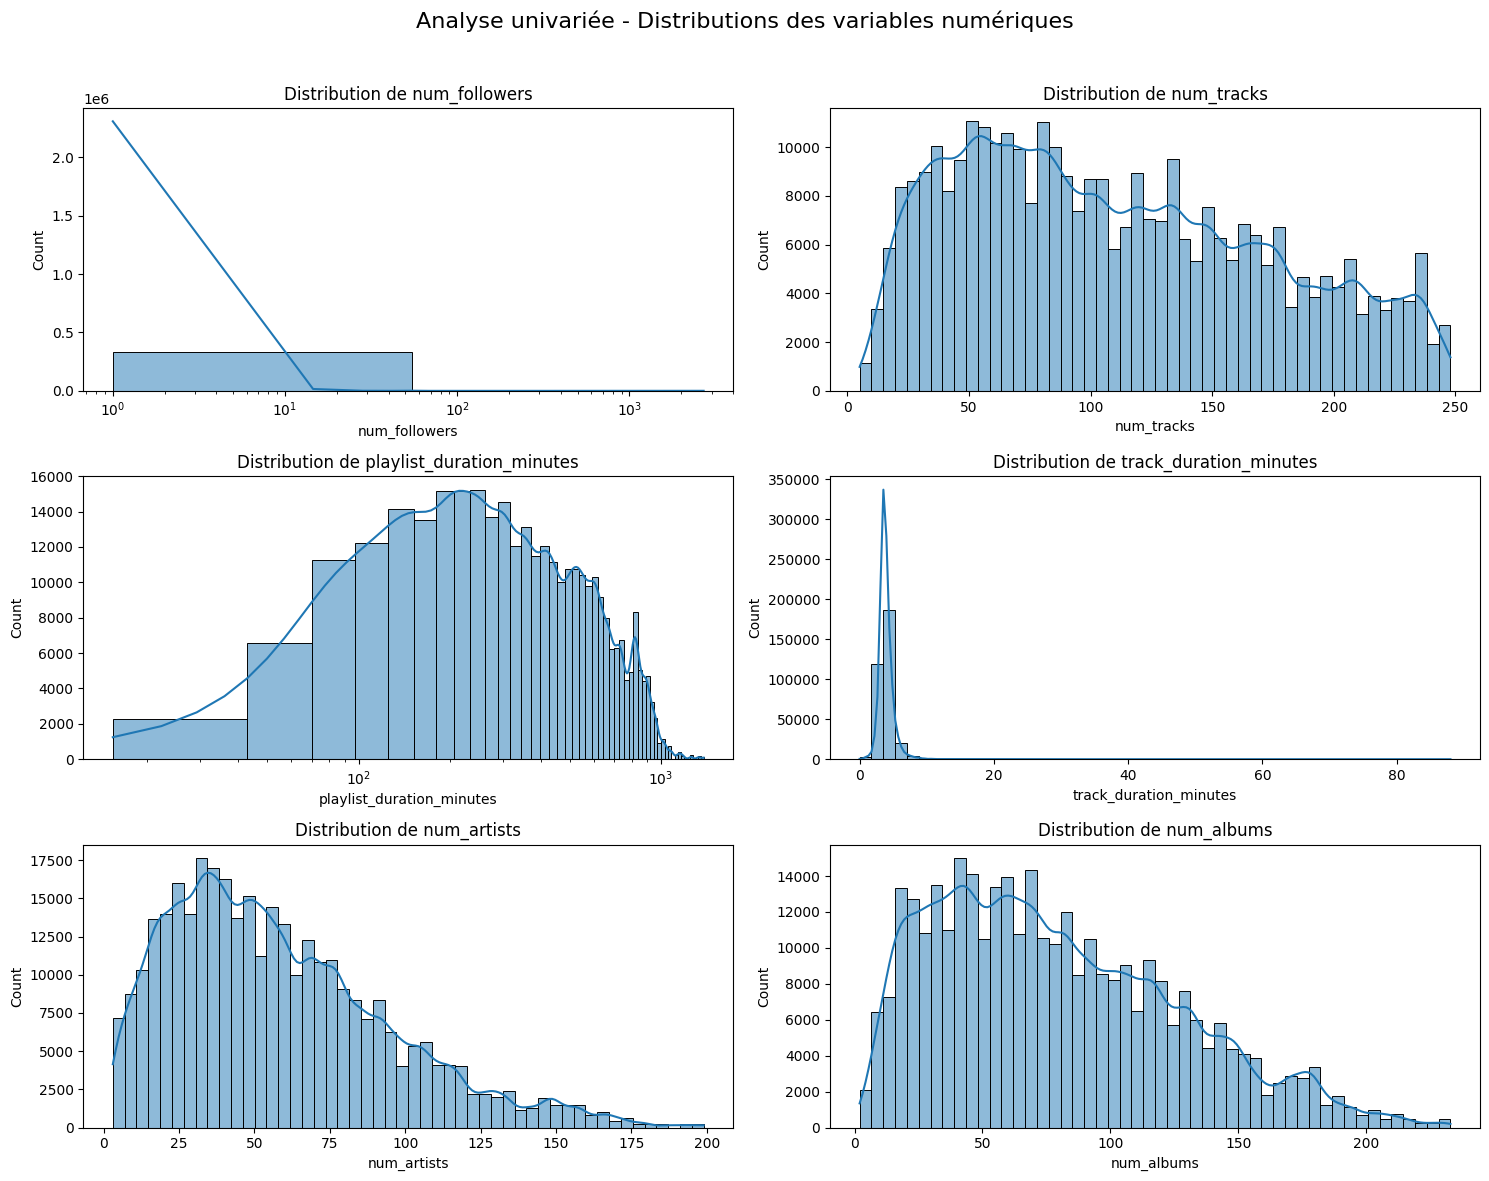

In [23]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'playlist_duration_minutes', 'track_duration_minutes', 'num_artists', 'num_albums']

plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univariée - Distributions des variables numériques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'échelle log est utile pour les données très asymétriques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univariées sauvegardés : {univariate_plot_path}")
plt.show()
plt.close()


Boxplots sauvegardés : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_2_boxplots_numeriques.png


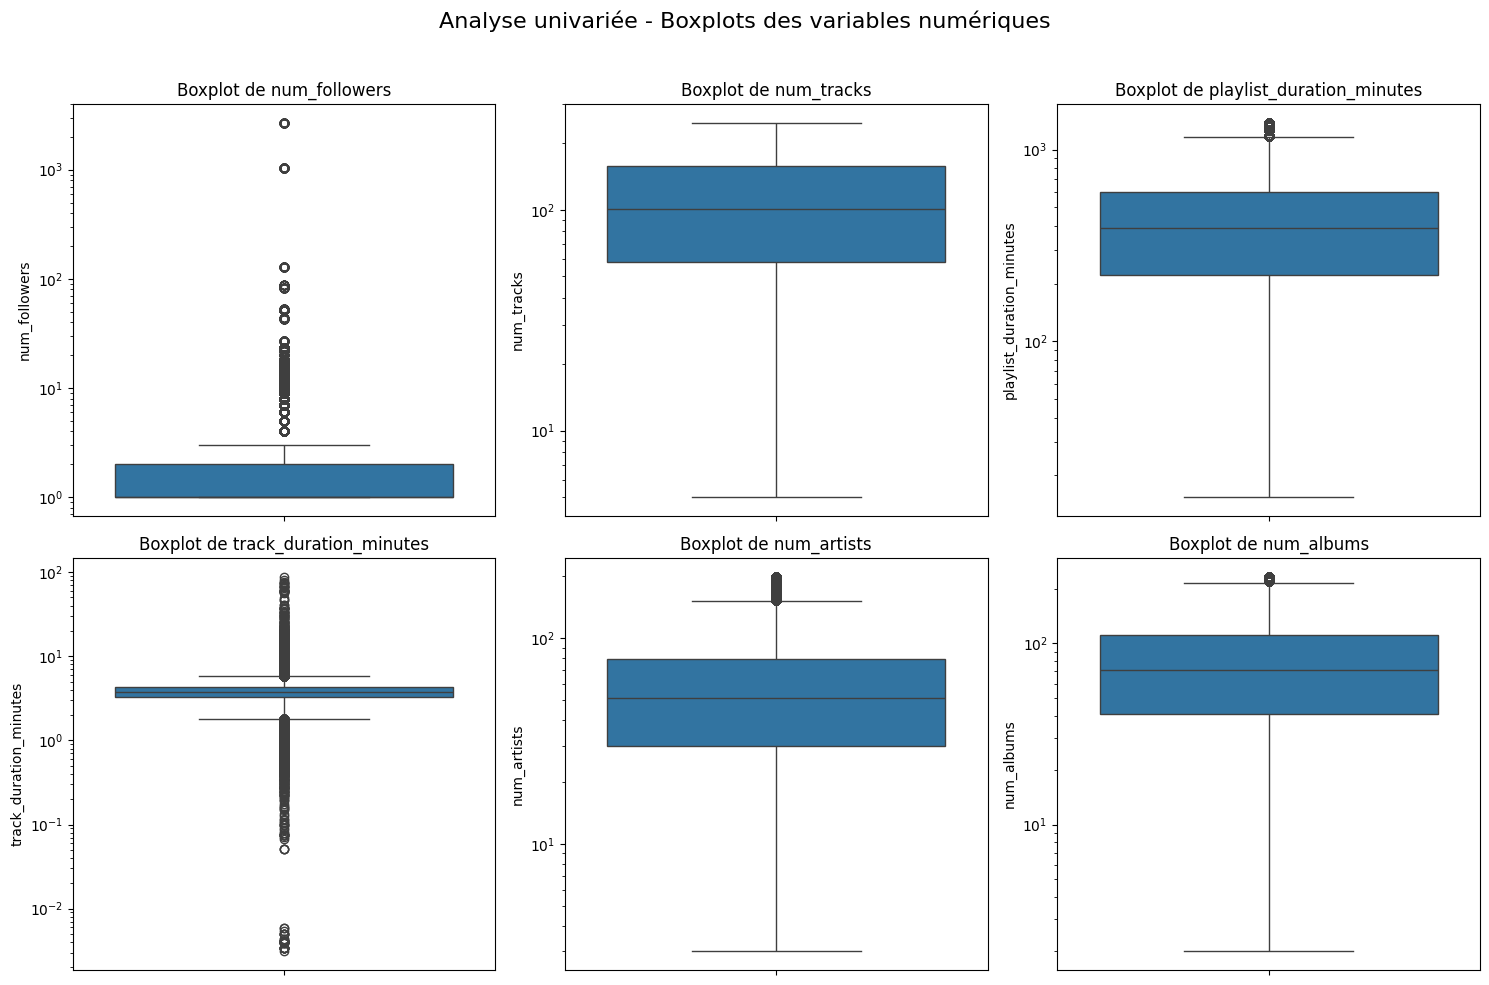

In [24]:
# Boxplots pour les variables numériques
plt.figure(figsize=(15, 10))
plt.suptitle('Analyse univariée - Boxplots des variables numériques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_box_path = os.path.join(output_dir, 'univar_2_boxplots_numeriques.png')
plt.savefig(univariate_box_path)
print(f"Boxplots sauvegardés : {univariate_box_path}")
plt.show()
plt.close()

C:\Users\giorg\AppData\Local\Temp\ipykernel_21804\1432556163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


Graphique 'Top 20 des artistes les plus fréquents' sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_3_top20_artistes.png


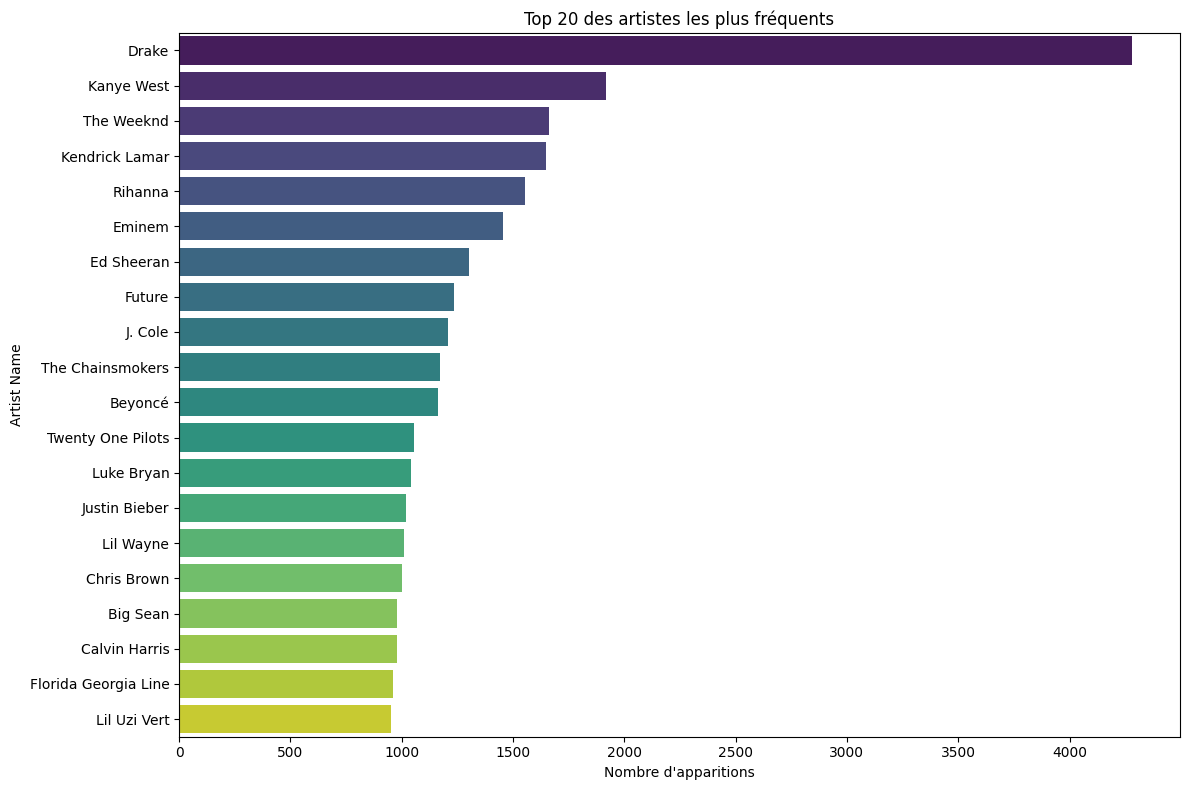

C:\Users\giorg\AppData\Local\Temp\ipykernel_21804\1432556163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


Graphique 'Top 20 des albums les plus fréquents' sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_4_top20_albums.png


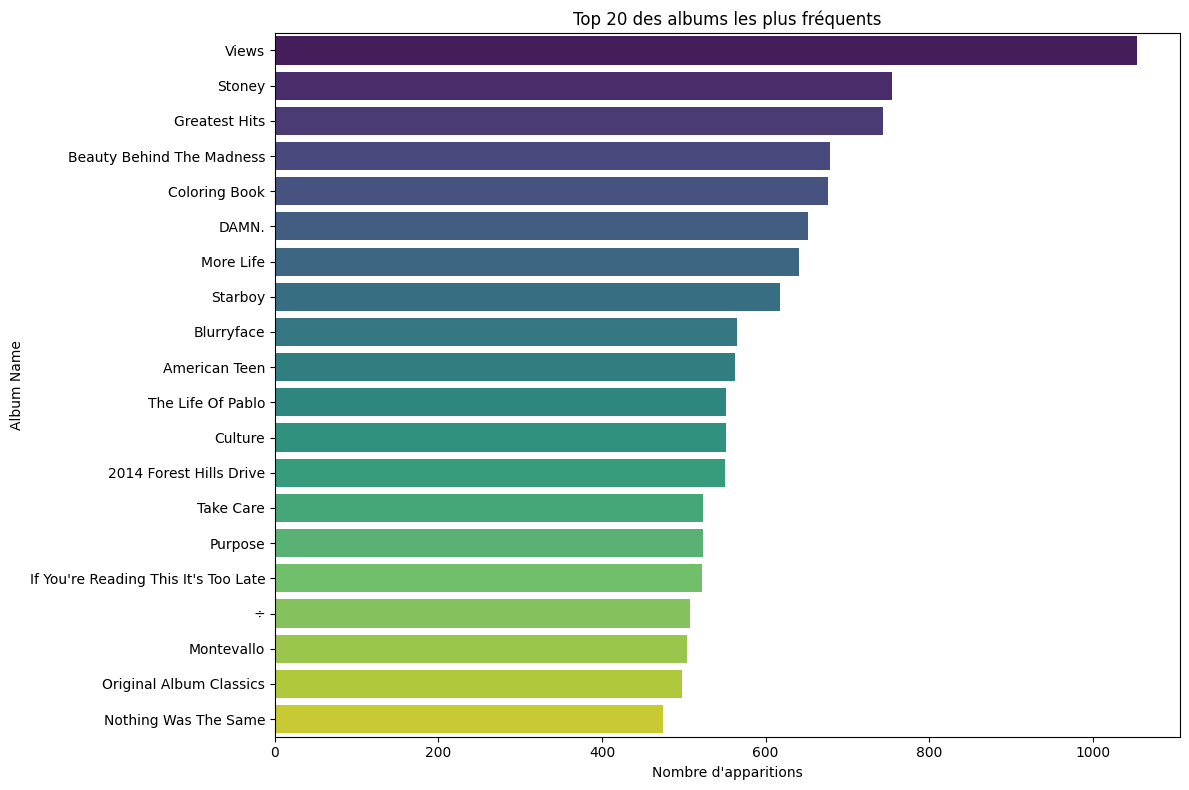

In [25]:
# Analyse des variables catégorielles (Top 20)
def plot_top_n(data, column, n, title, path):
    plt.figure(figsize=(12, 8))
    top_n = data[column].value_counts().nlargest(n)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(title)
    plt.xlabel("Nombre d'apparitions")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(path)
    print(f"Graphique '{title}' sauvegardé : {path}")
    plt.show()
    plt.close()

plot_top_n(df, 'artist_name', 20, 'Top 20 des artistes les plus fréquents', os.path.join(output_dir, 'univar_3_top20_artistes.png'))
plot_top_n(df, 'album_name', 20, 'Top 20 des albums les plus fréquents', os.path.join(output_dir, 'univar_4_top20_albums.png'))

Nuage de mots sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_5_wordcloud_noms_playlist.png


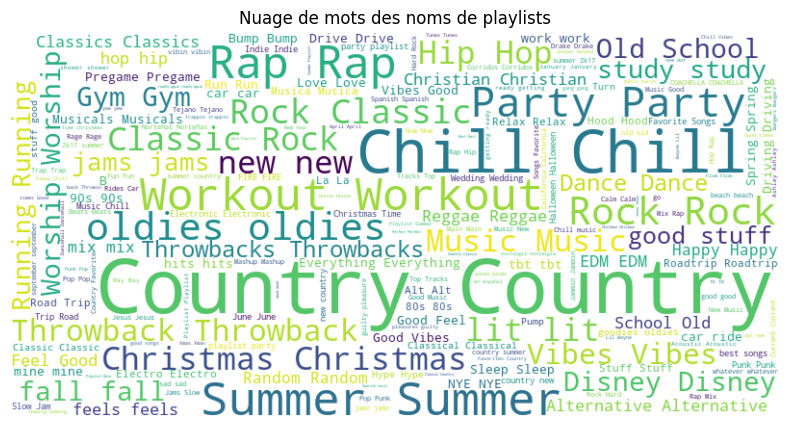

In [26]:
# Nuage de mots pour les noms de playlists
playlist_names = ' '.join(df['name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(playlist_names)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des noms de playlists')
wordcloud_path = os.path.join(output_dir, 'univar_5_wordcloud_noms_playlist.png')
plt.savefig(wordcloud_path)
print(f"Nuage de mots sauvegardé : {wordcloud_path}")
plt.show()
plt.close()

Matrice de corrélation sauvegardée : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_1_matrice_correlation.png


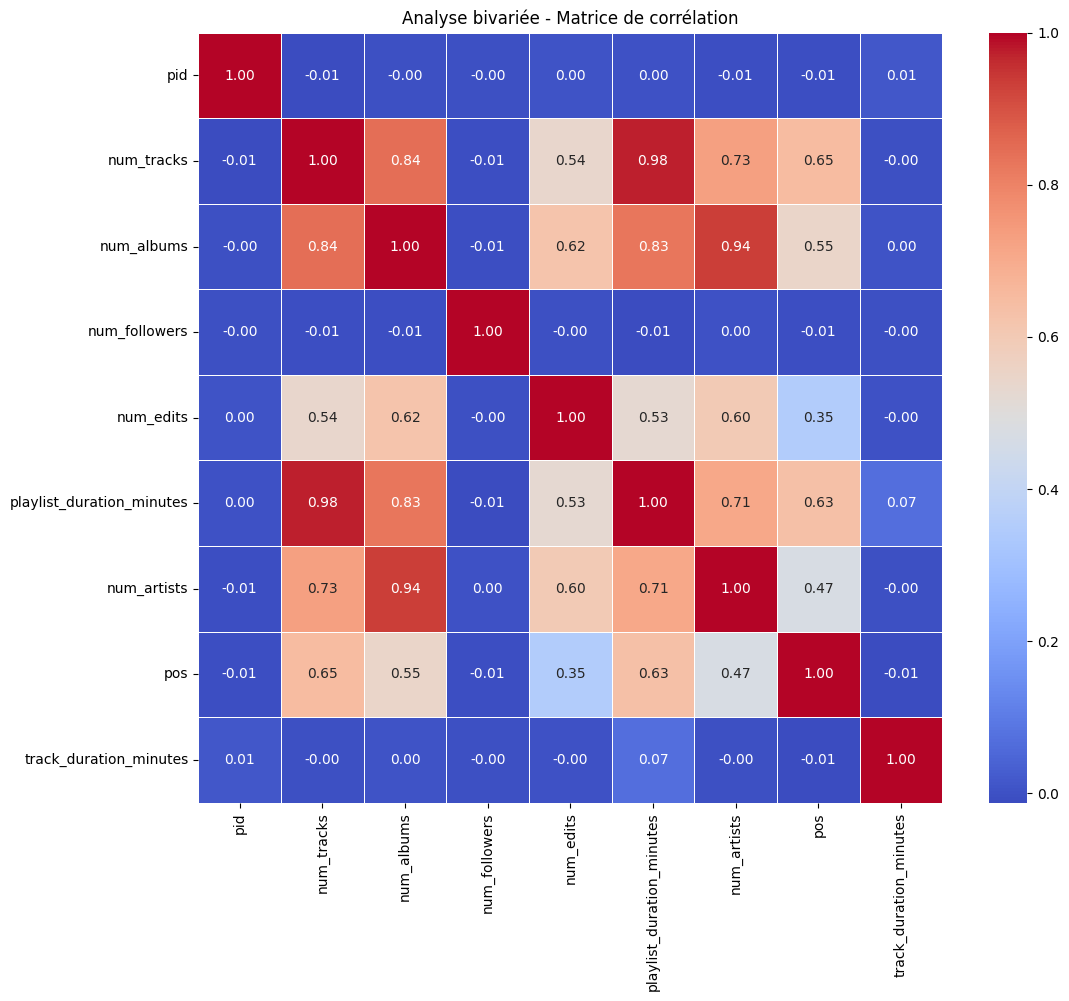

In [28]:
# B. Analyse bivariée
# Matrice de corrélation
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Analyse bivariée - Matrice de corrélation')
bivariate_plot_path = os.path.join(output_dir, 'bivar_1_matrice_correlation.png')
plt.savefig(bivariate_plot_path)
print(f"Matrice de corrélation sauvegardée : {bivariate_plot_path}")
plt.show()
plt.close()

Pairplot sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_2_pairplot.png


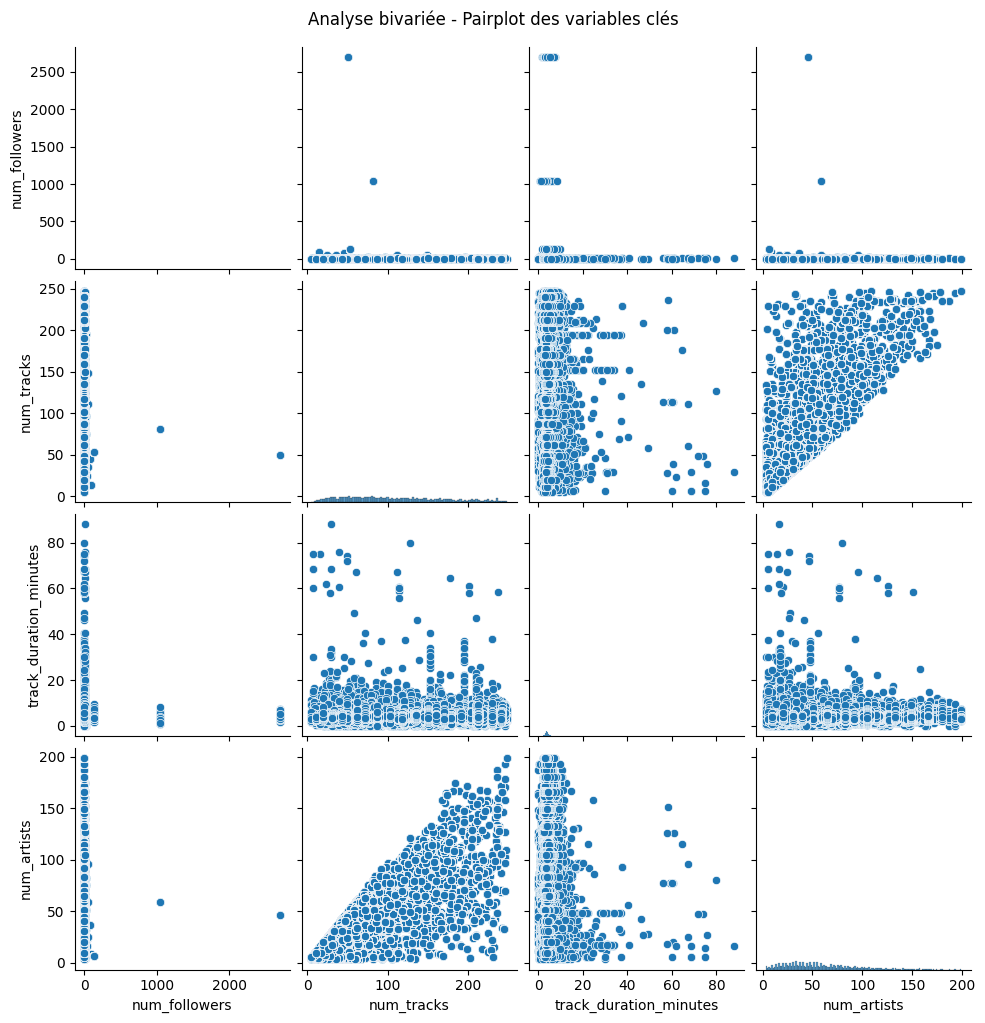

In [30]:
# Pairplot pour les variables clés
pairplot_cols = ['num_followers', 'num_tracks', 'track_duration_minutes', 'num_artists']
sns.pairplot(df[pairplot_cols].dropna())
plt.suptitle('Analyse bivariée - Pairplot des variables clés', y=1.02)
pairplot_path = os.path.join(output_dir, 'bivar_2_pairplot.png')
plt.savefig(pairplot_path)
print(f"Pairplot sauvegardé : {pairplot_path}")
plt.show()
plt.close()

Nuage de points sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_3_scatter_pistes_followers.png


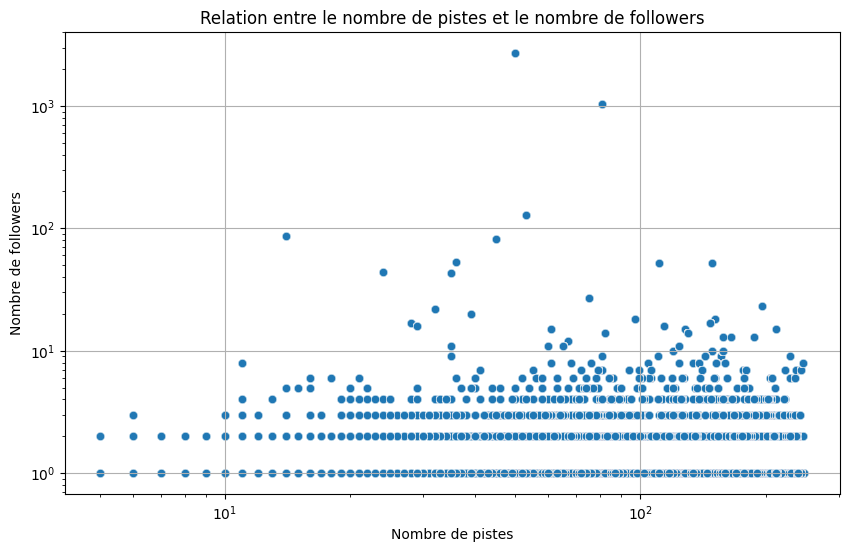


--- Analyse exploratoire terminée ---
Tous les graphiques ont été sauvegardés dans : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots


In [31]:
# Scatter plot spécifique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_tracks', y='num_followers', alpha=0.5)
plt.title('Relation entre le nombre de pistes et le nombre de followers')
plt.xlabel('Nombre de pistes')
plt.ylabel('Nombre de followers')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
scatter_path = os.path.join(output_dir, 'bivar_3_scatter_pistes_followers.png')
plt.savefig(scatter_path)
print(f"Nuage de points sauvegardé : {scatter_path}")
plt.show()
plt.close()

print("\n--- Analyse exploratoire terminée ---")
print(f"Tous les graphiques ont été sauvegardés dans : {output_dir}")